<a href="https://colab.research.google.com/github/GDS-Education-Community-of-Practice/DSECOP/blob/main/01_Symbolic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Symbolic Regression





The goal of this notebook is to simultaneously introduce students to symbolic regression and the techniques physicists use for problem solving. Symbolic regression is a form of machine learning that combines mathematical operations to try and find the expression that best matches a given dataset e.g. ( trying F=m+a, F=m*a, F=m^a, etc.) This technique has been historically unpopular, but has had a recent resurgence due to novel physics-inspired techniques. In this notebook we will implement the [AI Feynman algorithm](https://www.science.org/doi/10.1126/sciadv.aay2631) created by Max Tegmark and Silviu Udrescu and explore the data science and physics behind it. Let's start by looking at a flowchart of the algorithm:

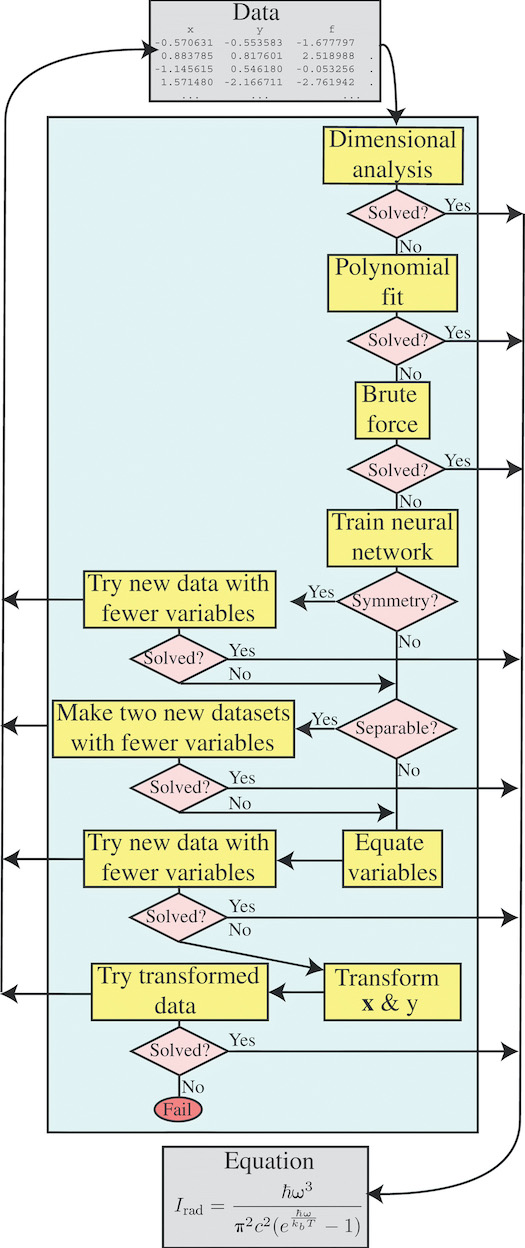

Before we get into the details of the algorithm, we need a dataset. Let's create a dataframe of various formulae as well as the units used by different physical quantities e.g. ([mass]=kg)

In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
formulae={'Output':['F','V','U','K'],'Formula':['m*a','I*R','.5*k*(x1-x2)**2','.5*m*(vx**2+vy**2)'], '# variables':[2,2,3,3],'v1_name':['m','I','k','m'],'v1_low':[1,1,1,1],'v1_high':[2,5,5,2],'v2_name':['a','R','x1','vx'],'v2_low':[1,1,1,1],'v2_high':[5,5,5,5],'v3_name':[np.nan,np.nan,'x2','vy'],'v3_low':[np.nan,np.nan,1,1],'v3_high':[np.nan,np.nan,5,5]}

df=pd.DataFrame(data=formulae)
df

,Output,Formula,# variables,v1_name,v1_low,v1_high,v2_name,v2_low,v2_high,v3_name,v3_low,v3_high
0,F,m*a,2,m,1,2,a,1,5,NaN,NaN,NaN
1,V,I*R,2,I,1,5,R,1,5,NaN,NaN,NaN
2,U,.5*k*(x1-x2)**2,3,k,1,5,x1,1,5,x2,1.0,5.0
3,K,.5*m*(vx**2+vy**2),3,m,1,2,vx,1,5,vy,1.0,5.0


Now let's generate some sample data to test our algorithm. This takes our formulae and generates random values within a physical range for the inputs and calculates the appropriate output. In the real world our data will be noisy and not perfectly fit the formulae! Having perfect "data" will help us test the algorithm without worrying about its robustness to errors in our data.

In [3]:
#Choose the number of points of data as well the number of the formula and the program will return a matrix with inputs and then the output
def DataGenerator(num_pts,var):
  data=[]
  num_var=df["# variables"].iloc[var]

  for j in range(num_pts):
    pts=[]
    formula=df["Formula"].iloc[var]
    for i in range(num_var):
      name=df.iloc[var,3*i+3]
      low=df.iloc[var,3*i+4]
      high=df.iloc[var,3*i+5]
      pt=random.uniform(low,high)
      pts.append(pt)
      formula=formula.replace(name,str(pt))
    pts.append(eval(formula))
    data.append(pts)
  return data

Let's explore the various modules of the algorithm!


 ## 1 . Dimensional Analysis:
  Physical quantities have units associated with them e.g. (Force is measured in Newtons, Speed in meters per second). When we have data with various units and know what units the answer takes we can analyze the combinations of units to see what answers make sense. For example if we measure the voltage[$kgm^2s^{-3}A^{-1}$] drop across a wire as well as the current[$A$], resistance[$kgm^2s^{-3}A^{-2}$], temperature[$K$], mass[$kg$], and length[$m$] of the wire, can we figure out what combination gives us the voltage?
 **Exercise 1: Use dimensional analysis to rediscover Ohm's Law**




We can use linear algebra to build an algorithm to do dimensional analysis for us. Let's first create a dataframe (a matrix with labels) where we can keep track of the units of various physical quantities

In [4]:
import pandas as pd
import numpy as np
from scipy import linalg

units={'Variable':['F','m','a','V','I','R','U','k','x1','x2','vx','vy','K'],'Units':['Force','Mass','Acceleration','Voltage','Current','Resistance','Energy','Spring Constant','Length','Length','Speed','Speed','Energy'],'m':[1,0,1,2,0,2,2,0,1,1,1,1,2],'s':[-2,0,-2,-3,0,-3,-2,-2,0,0,-1,-1,-2],'kg':[1,1,0,1,0,1,1,1,0,0,0,0,1],'Amp':[0,0,0,-1,1,-2,0,0,0,0,0,0,0]}
#Here we create a dataframe from a python dictionary. This allows us to call the entries by row or by name.
df_units=pd.DataFrame(data=units)
df_units

,Variable,Units,m,s,kg,Amp
0,F,Force,1,-2,1,0
1,m,Mass,0,0,1,0
2,a,Acceleration,1,-2,0,0
3,V,Voltage,2,-3,1,-1
4,I,Current,0,0,0,1
5,R,Resistance,2,-3,1,-2
6,U,Energy,2,-2,1,0
7,k,Spring Constant,0,-2,1,0
8,x1,Length,1,0,0,0
9,x2,Length,1,0,0,0


We can see that for example the values in the row corresponding to force are the sum of the rows for mass and acceleration. By keeping track of the appropriate powers of SI Units for our physical quantities, dimensional analysis for a target quantity reduces to the linear algebra problem of finding which vector of integers will reproduce the target row when multiplying the input rows.
Ex. We can see that Force has the units of mass*acceleration because $1*\begin{pmatrix}0\\0\\1\\0\end{pmatrix}+1*\begin{pmatrix}1\\-2\\0\\0\end{pmatrix}=\begin{pmatrix}1\\-2\\1\\0\end{pmatrix}$

Let's use Ohm's Law as an example. Our target quantity will be Voltage.

In [5]:
df_units

,Variable,Units,m,s,kg,Amp
0,F,Force,1,-2,1,0
1,m,Mass,0,0,1,0
2,a,Acceleration,1,-2,0,0
3,V,Voltage,2,-3,1,-1
4,I,Current,0,0,0,1
5,R,Resistance,2,-3,1,-2
6,U,Energy,2,-2,1,0
7,k,Spring Constant,0,-2,1,0
8,x1,Length,1,0,0,0
9,x2,Length,1,0,0,0


In [6]:
#We specify the output units and the input units, where row 3 is Voltage
voltage=df_units.iloc[3]
sans_voltage=df_units.drop(3)

#Turning dataframe into matrix to make linear algebra easier
output_vec=np.array(voltage.drop(['Variable','Units']),dtype=float)
input_matrix=np.array(sans_voltage.drop(columns=['Variable','Units']),dtype=float)


In order to do the dimensional analysis, we want to solve the equation $Nx=a$ for $x$, where $a$ is the power of each unit in our measured variable and $N$ is the matrix of powers of SI units associated with each unit. However our matrix $N$ is not square so we can't just invert it. This is okay as it is not a full rank matrix (meaning not all its rows and columns are independent). To solve our problem we then need to find an invertible $r\times r$ matrix (where $r$ is the rank of $N$).
All other powers will be 0.

In [7]:
  from numpy.linalg import matrix_rank
  from itertools import combinations



  def getpowers(input_matrix,output_vec):
    #Number of rows, columns, and rank of input_matrix
    row_num, col_num, rank = len(input_matrix),len(input_matrix[0]),matrix_rank(input_matrix)
    #The possible indices for rows and columns
    row_ind, col_ind=np.arange(row_num),np.arange(col_num)
    #All combinations of indices
    comb_col,comb_row = list(combinations(col_ind,col_num-rank)),list(combinations(row_ind,row_num-rank))
    #Now we look at every rank-by-rank submatrix to find a non-singular one to
    for i in comb_col:
      #Make a copy of our matrix and look at an rxr submatrix
      M = input_matrix
      M = np.delete(M,i,1)
      M = np.transpose(M)
      for j in comb_row:
        P = M
        P = np.delete(P,j,1)
        if np.linalg.det(P)!=0:
          #If we've found a non-zero minor then we have a solution
          solved_M = np.transpose(P)
          sol_col, sol_row = i, j
          break
    #We can now find the solution to the system by only considering the submatrix
    output_subset = np.delete(output_vec,sol_row)
    powers = np.linalg.solve(solved_M,output_subset)
    powers=powers.tolist()
    #Add 0s for the non-used units
    for n in sol_col:
      powers.insert(n,0)
    return np.array(powers,dtype=float)

In [8]:
getpowers(input_matrix.T,output_vec)
#Reading off we see that we got V=IR which is Ohm's law!

array([-0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

While we managed to discover Ohm's law quite quickly, it's not always so simple! Often there are multiple combinations of variables that give us the proper units or universal constants that have the units we need.

**Exercise 2: Use dimensional analysis to find the units of Newton's constant G, and Coulomb's constant k**

In [9]:
from sympy import Matrix, symbols

def variables_to_matrices(input_units,output_unit):
  #We want to be able to do the above calculation by only passing in variable names e.g. (acceleration, mass, voltage)
  #We assume input is a list of strings e.g. ['m','a'] and output is a lone string 'F'. F=ma
  def variable_to_array(variable):
    #This is hard to read, but the function of the below line is to return the index associated with the i'th element in input
    index=int(np.where(df_units["Variable"] == variable)[0])
    #This gives us an array which is the row associated with the quantity e.g. for acceleration we get [1,-2,1,0]
    return np.array(df_units.iloc[index].drop(['Variable','Units']),dtype=float)


  input_matrix=[]
  for i in input_units:
    row=variable_to_array(i)
    input_matrix.append(row)
  input_matrix=np.array(input_matrix)
  output_vec=variable_to_array(output_unit)
  #Outputs the solved and unsolved powers
  return getpowers(input_matrix.T,output_vec),Matrix(input_matrix.T).nullspace()

## 2. Polynomial Fit:
Many of the equations of physics are polynomials of relatively low degree e.g. (position as a function of time, energy as a function of position and velocity) so when trying to find the equation that fits our data it makes sense to check if this is the case.

In [75]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.metrics import mean_squared_error


#We input the data of our independent variables as well as the data of our dependent variable, while specifying the degree of the polynomial
def poly_fit(data,degree):
  independent=data[:,:-1]
  dependent=data[:,-1]



  poly = PolynomialFeatures(degree)
  independent = poly.fit_transform(independent)
  clf = linear_model.LinearRegression()
  ans=clf.fit(independent, dependent)
  #We return the coefficients of the polynomial

  #We calculate the root-mean-square error as specified in the algorithm
  predicted_values=clf.predict(independent)
  err=mean_squared_error(dependent,predicted_values,squared=False)



  return [err,np.round(ans.coef_,2)]


To check our polynomial fit let's use a simple example, projectile motion. Let's assume I've stood on a hill that's 200 meters tall and thrown a ball with initial velocity in the y direction of 30 meters per second. My classmate took a video of the ball's motion and tracked its height as a function of time. Can my classmate figure out how tall the hill is and how fast I threw the ball?

In [11]:
#Here we generate the data for the trajectory.
#We ask for 100 datapoints in between 0 and 10 seconds
t=np.linspace(0,10,100)
#We use the equation y(t)=-g/2t^2+v_yt+y_0 to generate our parabolic trajectory
y=[]
for i in t:
  y.append(-.5*9.8*i**2+30*i+200)
y=np.array(y)
poly_data=np.column_stack((t,y))

In [12]:
poly_fit(poly_data,4)

[7.731092880323636e-12, array([ 0. , 30. , -4.9,  0. , -0. ])]

The polynomial fit has correctly identified the acceleration of gravity 9.8 (N.B. that $\frac{-9.8}{2}=-4.9$), the y velocity at which the ball was thrown 30 m/s, the height of the hill 200, and the fact that the position of the ball is only a second order polynomial with 0 contributions from 3rd or 4th order terms.

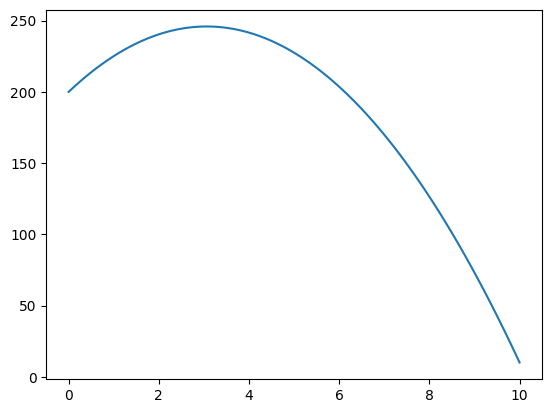

In [13]:
import matplotlib.pyplot as plt
plt.plot(t,y)

## 3. The Neural Network:
More details of the neural network are in the NeuralNet.ipynb file. In order to test if the function we're searching for is translationally-invariant or separable we want to be able to evaluate it at data points we didn't necessarily collect! For example if we want to test how invariant the function is to shifting $x_1$ and $x_2$ by the same amount (testing whether it's a function of $x_2-x_1$) we would need many data points where $x_1$ and $x_2$ differ by the same amount. A clever way to get these is to "fill-in" the missing data points by using a neural network. To do this we train the network on 80% of our data asking it to predict what result our function would give. Training consists of trying different things to minimize the error between the result it gives and the actual dependent variable data. We then "test" our network by having it predict the result of the last 20% of data and seeing how far away this is from the actual measured dependent variable.

In [14]:
#Here we import the contents of NeuralNet.py,
#which is reproduced in more readable format in NeuralNet.ipynb so you can play with the parameters and functions
!git clone https://github.com/GDS-Education-Community-of-Practice/DSECOP/
import sys
sys.path.append('/content/DSECOP/Symbolic_Regression/')
from NeuralNet import *

Cloning into 'DSECOP'...
remote: Enumerating objects: 2038, done.
remote: Counting objects: 100% (945/945), done.
remote: Compressing objects: 100% (614/614), done.
remote: Total 2038 (delta 423), reused 740 (delta 317), pack-reused 1093
Receiving objects: 100% (2038/2038), 134.82 MiB | 14.91 MiB/s, done.
Resolving deltas: 100% (980/980), done.


In [15]:
from sklearn.model_selection import train_test_split
#Here we generate values for k,x1,x2,F

def split_data(array_pos,num_pts,percent):
  data=np.array(DataGenerator(num_pts,array_pos))


  #Split into 80% training set and 20% testing set
  X_train,X_test,y_train,y_test=train_test_split(data[:,:-1],data[:,-1],test_size=percent)

  #Put them together in the appropriate formate
  train=np.column_stack((X_train,y_train))
  test=np.column_stack((X_test,y_test))
  return train,test

train,test = split_data(2,1000,0.2)

In [16]:
#This will take a minute or so to train
model=NN_train(train)

In [17]:
def predict(data):
  #We remove the dependent variable and then convert the numpy array to a pytorch tensor so the NeuralNet can predict its value.
  return model(torch.atleast_2d(torch.from_numpy(data[:,:-1]).to(torch.float32)))

In [18]:
NN_eval(test)[0]

tensor(0.0061, grad_fn=<DivBackward0>)

How good does our Neural Network do? Let's plot it against the actual function

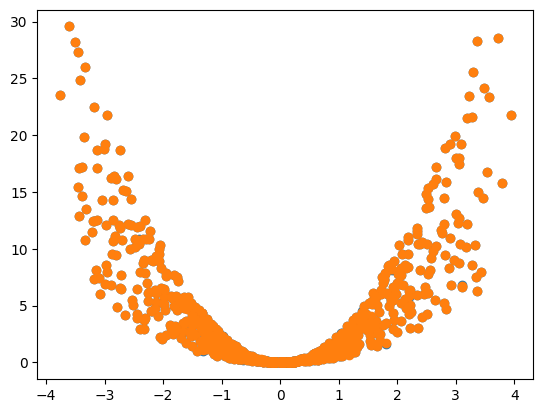

In [19]:
#Training Data
plt.scatter(train.T[1]-train.T[2],train[:,-1])
plt.scatter(train.T[1]-train.T[2],predict(train).detach().numpy().reshape(1,800)[0])

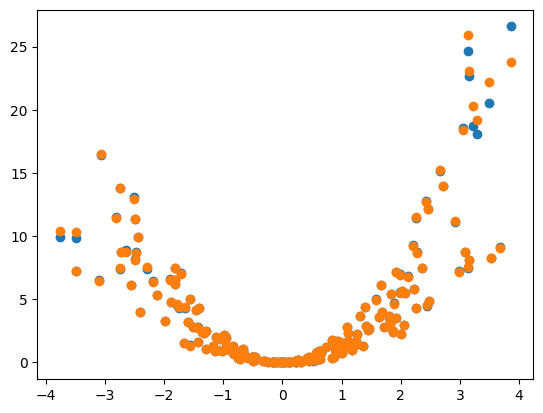

In [20]:
#Testing Data
plt.scatter(test.T[1]-test.T[2],test[:,-1])
plt.scatter(test.T[1]-test.T[2],predict(test).detach().numpy().reshape(1,200)[0])


As we see it gets some properties of the function right, but is not a perfect fit.

**Optional Exercise: Try editing the Neural Network to get a better fit! You can train for more epochs, use a deeper network, or use any of the tricks you learned in the Intro to Deep Learning module**

## 4. Symmetry:
Physicists often use the symmetry of systems to derive the equations that govern them. Consider the familiar expression for gravitational force between two bodies $F=G\frac{m_1m_2}{r^2}$. Although we may collect the data of the positions in the x,y,z directions for both bodies the force between them only depends on the distance between them. We call this "translation symmetry," meaning that if we were to translate (or move) BOTH of the bodies by the same amount the force between them wouldn't change since it only depends on the difference of their positions. Finding symmetry will make our expression simpler and therefore easier to find!

**Exercise 3: Can you think of 3 equations you've learned that have translation symmetry?**

In [21]:
def symmetry(data):
  #How much we shift the data by
  a=1
  #We shift the data for 2 of the variables by the same amount for each set of 2 variables.
  #We then check the root-mean-squared-error loss between the two predictions
  #If it's less than 7 times the error of the prediction then we call it symmetric
  #7 seems arbitrary and it is! This is a 'hyperparameter' a number in your network you're free to make whatever increases performance.
  for i in range(len(data.T)-1):
    for j in range(len(data.T)-1):
      if i<j:
        copy=[]
        for row in data:
          copy_row=[]
          for k in range(len(row)):
            if k==i or k==j:
              copy_row.append(row[k]+a)
            else:
              copy_row.append(row[k])

          copy.append(copy_row)





        copy=np.array(copy)

        #Predict the outcome of the shifted copy and the original
        pred_cop=predict(copy)
        pred_dat=predict(data)
        #Error between them
        err1=rmse_loss(pred_cop,pred_dat)
        err2=rmse_loss(pred_dat,torch.atleast_2d(torch.from_numpy(data[:,-1]).to(torch.float32)))

        if(err1/err2<7):
          return [err1/err2,[i,j]]



In [22]:
#As we can see x_1 and x_2 are translation symmetric!
#Therefore we should really train our data on x_2-x_1
symmetry(test)

/content/DSECOP/Symbolic_Regression/NeuralNet.py:193: UserWarning: Using a target size (torch.Size([1, 200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return torch.sqrt(F.mse_loss(pred, targ))/denom


[tensor(1.2003, grad_fn=<DivBackward0>), [1, 2]]

## 5. Separability:
A function $f(x,y)$ is multiplicatively separable if it can be written $f(x,y)=g(x)h(y)$ and additively separable if it can be written $f(x,y)=g'(x)+h'(y)$.

**Exercise 4: Consider a ball moving in 2 dimensions. It's total energy (kinetic energy + potential energy) is a function of velocity in the x direction, velocity in the y direction, position in the x direction, and position in the y direction. What types of separability and translational symmetry does its total energy have?**

f(x,y)
f(c1,y)
f(x,c2)

f(c1,y)+f(x,c2)-f(c1,c2)=f(x,y)
f(x,y)=g(x)+h(y)


In [23]:
#We only test additive separability as it was pointed out in the paper that the log of a multiplicatively separable function is additively separable.
#ln(f(x)g(y))=ln(f(x))+ln(g(y))
def separability(data):
  means=[]
  for i in range(len(data.T)-1):
    means.append(np.mean(data[:,i]))

  for i in range(len(data.T)-1):
    for j in range(len(data.T)-1):
      if i<j:
        copyi=[]
        copyj=[]
        copyij=[]
        for row in data:

          copyi_row=[]
          copyj_row=[]
          copyij_row=[]
          for k in range(len(row)):
            if k==i:
              copyi_row.append(means[k])
              copyj_row.append(row[k])
              copyij_row.append(means[k])
            elif k==j:
              copyi_row.append(row[k])
              copyj_row.append(means[k])
              copyij_row.append(means[k])
            else:
              copyi_row.append(row[k])
              copyj_row.append(row[k])
              copyij_row.append(row[k])

          copyi.append(copyi_row)
          copyj.append(copyj_row)
          copyij.append(copyij_row)

        copyi=np.array(copyi)
        copyj=np.array(copyj)
        copyij=np.array(copyij)


        #Predictions for f(x1,c2),f(c1,x2), f(c1,c2) and f(x1,x2)
        pred_copi=predict(copyi)
        pred_copj=predict(copyj)
        pred_copij=predict(copyij)
        pred_dat=predict(data)

        fk=pred_copi+pred_copj-pred_copij


        err1=rmse_loss(pred_copi+pred_copj-pred_copij,pred_dat)
        err2=rmse_loss(pred_dat,torch.atleast_2d(torch.from_numpy(data[:,-1]).to(torch.float32)))

        if err1/err2 <1:
          return [err1/err2,[i,j]]







In [24]:
#Let's create a separable data set for kinetic energy
train2,test2 = split_data(3,1000,0.2)

model=NN_train(train2)

In [25]:
#Our network is able to tell us that kinetic energy is additively separable in vx and vy
separability(test2)

[tensor(0.0250, grad_fn=<DivBackward0>), [1, 2]]

## 6. Putting it all together:
Let's assemble the full algorithm now from the flow chart. First we do dimensional analysis and if it doesn't solve for the equation put things in terms of dimensionless variables. Then we split into training and testing samples. On the training sample we try a polynomial fit,  symmetry, and separability. We apply whichever works best and try them all again. Once the error gets small enough we try our found expression on the test data and output the error.

In [122]:
def poly_vars(vars,degree=4):
  #need for variable length of variables
  output=[]
  for n in range(degree):
    list_=[]
    for i in range(degree):
      for j in range(degree):
        for k in range(degree):
          if (i+j+k==n):
            list_.append(str(vars[0])+'^'+'{'+str(i)+'}'+str(vars[1])+'^'+str(j)+str(vars[2])+'^'+str(k))
    list_.reverse()
    for el in list_:
      output.append(el)
  return output


In [124]:
def poly(poly_out,var):
  empt=[]
  monomials=poly_vars(var)
  for i in range(len(poly_out)):
    if poly_out[i]!=0:
      empt.append(str(poly_out[i])+str(monomials[i]))
  a=0
  for j in empt:
    a+=symbols(j)
  return a

In [27]:
def var_to_names(var):
  names=[]
  num_var=df["# variables"].iloc[var]
  formula=df["Formula"].iloc[var]
  for i in range(num_var):
    name=df.iloc[var,3*i+3]
    names.append(name)
  names.append(df.iloc[var,0])
  return names

We create some functions that allow us to ouptut our polynomial symbolically

In [125]:
#We see here that it reproduces the spring potential energy
poly(poly_fit(test,4)[1],var_to_names(2)[:-1])

-1.0k^{1}x1^1x2^1 + 0.5k^{1}x1^0x2^2 + 0.5k^{1}x1^2x2^0

In [57]:
def tensor_to_float(tensor):
  temp=tensor.detach().numpy()
  return float(temp)

In [28]:
def trans_sym(data,index):
  new_data=[]
  for i in range(len(data)):
    new_row=[]
    new_var=0
    for j in index:
      new_var+=data[i,j]
      new_var=-new_var
    new_row.append(new_var)
    for k in range(len(data[0])):
      if k not in index:
        new_row.append(data[i,k])
    new_data.append(new_row)
  return new_data

In [29]:
def separate(data,index):
  means=[]
  for i in range(len(data.T)-1):
    means.append(np.mean(data[:,i]))

  i=index[0]
  j=index[1]
  copyi=[]
  copyj=[]
  copyij=[]
  for row in data:
    copyi_row=[]
    copyj_row=[]
    for k in range(len(row)):
      if k==i:
        copyi_row.append(means[k])
        copyj_row.append(row[k])
      elif k==j:
        copyi_row.append(row[k])
        copyj_row.append(means[k])
      else:
        copyi_row.append(row[k])
        copyj_row.append(row[k])

    copyi.append(copyi_row)
    copyj.append(copyj_row)

  copyi=np.array(copyi)
  copyj=np.array(copyj)
  print(len(data),len(copyi))
  return [data-copyi,data-copyj]



Now we can put all our functions together!

In [62]:
def decompose(data,var):
  names=var_to_names(var)


  error=[]
  error.append(poly_fit(data,4)[0])
  error.append(tensor_to_float(symmetry(data)[0]))
  error.append(tensor_to_float(separability(data)[0]))
  winner_index=np.argmin(error)
  min_err=min(error)
  if (winner_index==0):
    #If a polynomial fit is best return the polynomial
    return poly(poly_fit(data,4)[1],names[:-1])
  elif (winner_index==1):
    #If there's translation symmetry, replace the dataset with the new variable and go again
    decompose(trans_sym(data,symmetry(data)[1]))
  elif (winner_index==2):
    #If there's separability, then separate the functions and go again.
    parts=separate(data,separability(data)[1])
    decompose(parts[0])
    decompose(parts[1])
  else:
    print("Index of Winner not found")
    raise

  return min_err